### Data preprocessing


To get started, let's read in data from last eight Stack Overflow surveys

In [85]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

df16 = pd.read_csv('./data/2016 Stack Overflow Survey Responses.csv', low_memory=False)
df17 = pd.read_csv('./data/2017_survey_results_public.csv', low_memory=False)
df18 = pd.read_csv('./data/2018_survey_results_public.csv', low_memory=False)
df19 = pd.read_csv('./data/2019_survey_results_public.csv', low_memory=False)
df20 = pd.read_csv('./data/2020_survey_results_public.csv', low_memory=False)


Now to look at our first question of interest: How the technology stack has evolved over the years?  Looking at the shapes of dataframes and labels of columns, you can see that survey also changed over the years.

In [249]:
print(df16.shape, df17.shape, df18.shape, df19.shape, df20.shape)
print('\n16Y: \n', df16.columns)
print('\n17Y: \n', df17.columns)
print('\n17Y&18Y&19Y: \n', set(df17.columns).intersection(set(df18.columns), set(df19.columns), set(df20.columns)))

(56030, 66) (51392, 154) (98855, 129) (88883, 85) (64461, 61)

16Y: 
 Index(['Unnamed: 0', 'collector', 'country', 'un_subregion', 'so_region',
       'age_range', 'age_midpoint', 'gender', 'self_identification',
       'occupation', 'occupation_group', 'experience_range',
       'experience_midpoint', 'salary_range', 'salary_midpoint',
       'big_mac_index', 'tech_do', 'tech_want', 'aliens',
       'programming_ability', 'employment_status', 'industry',
       'company_size_range', 'team_size_range', 'women_on_team', 'remote',
       'job_satisfaction', 'job_discovery', 'dev_environment',
       'commit_frequency', 'hobby', 'dogs_vs_cats', 'desktop_os',
       'unit_testing', 'rep_range', 'visit_frequency', 'why_learn_new_tech',
       'education', 'open_to_new_job', 'new_job_value', 'job_search_annoyance',
       'interview_likelihood', 'how_to_improve_interview_process',
       'star_wars_vs_star_trek', 'agree_tech', 'agree_notice',
       'agree_problemsolving', 'agree_diversity',

Data layout and column names:

In [250]:
for d in [df16, df17, df18, df19, df20]:
    print('----->')
    for l in ['C++', 'Java', 'JavaScript', 'Python']:
        print(l, d.columns[d.apply(lambda x: x == l).any()])

----->
C++ Index(['tech_do', 'tech_want'], dtype='object')
Java Index(['tech_do', 'tech_want'], dtype='object')
JavaScript Index(['tech_do', 'tech_want'], dtype='object')
Python Index(['tech_do', 'tech_want'], dtype='object')
----->
C++ Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
Java Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
JavaScript Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
Python Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
----->
C++ Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
Java Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
JavaScript Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
Python Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
----->
C++ Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='object')
Java Index(['LanguageWorkedWith', 'LanguageDesireNextYear'], dtype='obj

In [88]:
print(df16['tech_do'].value_counts(), df16['tech_want'].value_counts())
print(df19.value_counts(subset=['LanguageDesireNextYear', 'LanguageWorkedWith']))

Java                                                                                                                                                               843
C#                                                                                                                                                                 606
C#; JavaScript; SQL; SQL Server                                                                                                                                    561
Android; Java                                                                                                                                                      515
Python                                                                                                                                                             501
                                                                                                                                                                  ...

In [89]:
df16

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,...,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
0,1888,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4637,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,...,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...
2,11164,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21378,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,Female,Engineer,DevOps,...,I don't care about this,This is somewhat important,This is very important,This is very important,I don't care about this,I don't care about this,This is very important,This is somewhat important,Corporate policies; Interacting with non-techn...,To get help for my job; Beacause I love to learn
4,30280,Facebook,Afghanistan,Southern Asia,Central Asia,> 60,65.0,Prefer not to disclose,Developer; Engineer; Programmer; Sr. Developer...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56025,51249,Twitter,NaN,NaN,NaN,40-49,44.5,Male,Developer; Programmer; Sr. Developer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56026,51834,Twitter,NaN,NaN,NaN,40-49,44.5,Male,Developer; Engineer; Programmer,Student,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56027,52126,Twitter,NaN,NaN,NaN,50-59,54.5,NaN,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56028,52144,Twitter,NaN,NaN,NaN,NaN,NaN,Male,Full-stack Developer; Full Stack Overflow Deve...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
def split_by(df, col, splitter):
    dummies = {}
    size = df.shape[0]
    for i, el in enumerate(df[col]):
        if pd.isna(el):
            continue
        for l in el.replace(' ', '').split(splitter):
            if l in dummies:
                dummies[l][i] = 1
            else:
                dummies[l] = [0]*size
    return pd.DataFrame(dummies)

df1 = pd.DataFrame({
    '16Y': split_by(df16, 'tech_do', ';').sum(),
    '17Y': split_by(df17, 'HaveWorkedLanguage', ';').sum(),
    '18Y': split_by(df18, 'LanguageWorkedWith', ';').sum(),
    '19Y': split_by(df19, 'LanguageWorkedWith', ';').sum(),
    '20Y': split_by(df20, 'LanguageWorkedWith', ';').sum()
             })

df2 = pd.DataFrame({
    '16Y': split_by(df16, 'tech_want', ';').sum(),
    '17Y': split_by(df17, 'WantWorkLanguage', ';').sum(),
    '18Y': split_by(df18, 'LanguageDesireNextYear', ';').sum(),
    '19Y': split_by(df19, 'LanguageDesireNextYear', ';').sum(),
    '20Y': split_by(df20, 'LanguageDesireNextYear', ';').sum()
             })

In [105]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df1 = (df1/df1.sum())
df2 = (df2/df2.sum())
cmp = pd.concat([df1,df2], keys=['current', 'wanted'], axis=1).sort_values(('current','20Y'), ascending=False)

<AxesSubplot:>

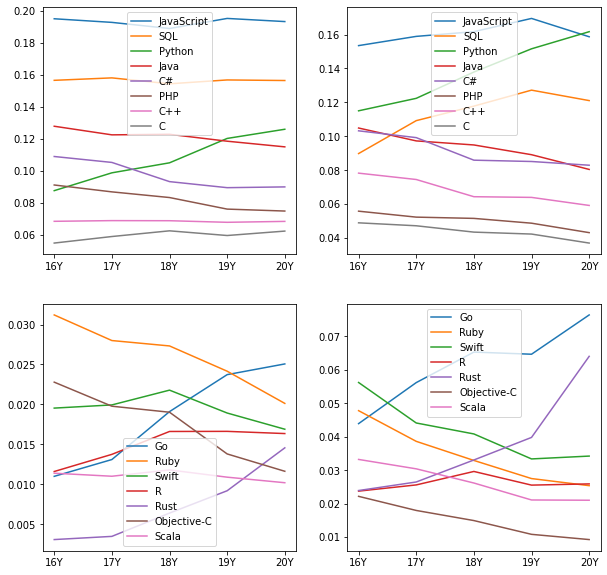

In [106]:
fig, axs = plt.subplots(2, 2)
cmp['current'][:8].T.plot(ax=axs[0,0], figsize=(10,10))
cmp['current'][8:].T.plot(ax=axs[1,0], figsize=(10,10))
cmp['wanted'][:8].T.plot(ax=axs[0,1], figsize=(10,10))
cmp['wanted'][8:].T.plot(ax=axs[1,1], figsize=(10,10))

In [ ]:
df16

In [107]:
_df16 = pd.concat([df16, split_by(df16, 'tech_do', ';'), split_by(df16, 'tech_want', ';').add_prefix('want_')], axis=1)
_df17 = pd.concat([df17, split_by(df17, 'HaveWorkedLanguage', ';'), split_by(df17, 'WantWorkLanguage', ';').add_prefix('want_')], axis=1)
_df18 = pd.concat([df18, split_by(df18, 'LanguageWorkedWith', ';'), split_by(df18, 'LanguageDesireNextYear', ';').add_prefix('want_')], axis=1)
_df19 = pd.concat([df19, split_by(df19, 'LanguageWorkedWith', ';'), split_by(df19, 'LanguageDesireNextYear', ';').add_prefix('want_')], axis=1)
_df20 = pd.concat([df20, split_by(df20, 'LanguageWorkedWith', ';'), split_by(df20, 'LanguageDesireNextYear', ';').add_prefix('want_')], axis=1)

In [109]:
for l in ['Python', 'Java', 'C++', 'JavaScript']:
    print(_df16.loc[_df16[l] == 1]['tech_do'].apply(lambda x: l in x).all())
    print(_df17.loc[_df17[l] == 1]['HaveWorkedLanguage'].apply(lambda x: l in x).all())
    print(_df18.loc[_df18[l] == 1]['LanguageWorkedWith'].apply(lambda x: l in x).all())
    print(_df19.loc[_df19[l] == 1]['LanguageWorkedWith'].apply(lambda x: l in x).all())
    print(_df20.loc[_df20[l] == 1]['LanguageWorkedWith'].apply(lambda x: l in x).all())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [110]:
for l in ['want_Python', 'want_Java', 'want_C++', 'want_JavaScript']:
    ll = l.split('_')[1]
    print(_df16.loc[_df16[l] == 1]['tech_want'].apply(lambda x: ll in x).all())
    print(_df17.loc[_df17[l] == 1]['WantWorkLanguage'].apply(lambda x: ll in x).all())
    print(_df18.loc[_df18[l] == 1]['LanguageDesireNextYear'].apply(lambda x: ll in x).all())
    print(_df19.loc[_df19[l] == 1]['LanguageDesireNextYear'].apply(lambda x: ll in x).all())
    print(_df20.loc[_df20[l] == 1]['LanguageDesireNextYear'].apply(lambda x: ll in x).all())

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [111]:
_df16.groupby('country')['Python'].sum().sort_values(ascending=False)[:10]

country
United States         3632
United Kingdom        1016
Germany                829
India                  648
Canada                 527
Poland                 373
France                 363
Russian Federation     353
Sweden                 304
Australia              265
Name: Python, dtype: int64

In [117]:
_df18.loc[_df18['Python'] == 1]['Country'].value_counts()['Poland']

609

In [211]:
python = pd.DataFrame({'16Y': _df16.groupby('country')['Python'].sum()/_df16['tech_do'].notna().sum(),
              '17Y': _df17.groupby('Country')['Python'].sum()/_df17['HaveWorkedLanguage'].notna().sum(),
              '18Y': _df18.groupby('Country')['Python'].sum()/_df18['LanguageWorkedWith'].notna().sum(),
              '19Y': _df19.groupby('Country')['Python'].sum()/_df19['LanguageWorkedWith'].notna().sum(),
              '20Y': _df20.groupby('Country')['Python'].sum()/_df20['LanguageWorkedWith'].notna().sum()
             })

<AxesSubplot:>

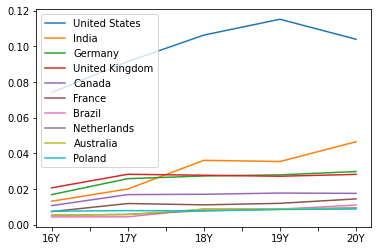

In [212]:
python.sort_values(by='20Y', ascending=False)[:10].T.plot()

In [133]:
for d in [df16, df17, df18, df19, df20]:
    print('----->')
    for c in d.columns:
        for t in ['Salary', 'salary', 'Comp', 'Currency', 'ountry']:
            if t in c: print(c)

----->
country
salary_range
salary_midpoint
----->
Country
CompanySize
CompanyType
UnderstandComputers
CompetePeers
AssessJobCompensation
ImportantHiringCompanies
Currency
StackOverflowCompanyPage
Salary
ExpectedSalary
----->
Country
CompanySize
Currency
Salary
SalaryType
ConvertedSalary
CurrencySymbol
HoursComputer
----->
Country
CurrencySymbol
CurrencyDesc
CompTotal
CompFreq
ConvertedComp
----->
CompFreq
CompTotal
ConvertedComp
Country
CurrencyDesc
CurrencySymbol


In [137]:
print('\ndf16: ', df16[['salary_range', 'salary_midpoint', 'country']].dropna())
print('\ndf17: ', df17[['Salary', 'Currency', 'Country']].dropna())
print('\ndf18: ', df18[['Salary', 'SalaryType', 'ConvertedSalary', 'Currency', 'CurrencySymbol', 'Country']].dropna())
print('\ndf19: ', df19[['CompTotal', 'CompFreq', 'ConvertedComp', 'CurrencyDesc', 'CurrencySymbol', 'Country']].dropna())
print('\ndf20: ', df20[['CompTotal', 'CompFreq', 'ConvertedComp', 'CurrencyDesc', 'CurrencySymbol', 'Country']].dropna())


df16:                salary_range  salary_midpoint      country
1        $40,000 - $50,000          45000.0  Afghanistan
3        Less than $10,000           5000.0  Afghanistan
6       More than $200,000         210000.0  Afghanistan
7        Less than $10,000           5000.0  Afghanistan
9        Less than $10,000           5000.0      Albania
...                    ...              ...          ...
56005  $110,000 - $120,000         115000.0      Uruguay
56006    Less than $10,000           5000.0   Uzbekistan
56007    Less than $10,000           5000.0   Uzbekistan
56008    Less than $10,000           5000.0    Venezuela
56009    Less than $10,000           5000.0      Vietnam

[41580 rows x 3 columns]

df17:                Salary                     Currency         Country
2      113750.000000  British pounds sterling (£)  United Kingdom
14     100000.000000  British pounds sterling (£)  United Kingdom
17     130000.000000             U.S. dollars ($)   United States
18      82

In [132]:
df17[['Currency', 'Country']].value_counts()

Currency                     Country       
U.S. dollars ($)             United States     5832
Indian rupees (?)            India             2146
British pounds sterling (£)  United Kingdom    2131
Euros (€)                    Germany           1900
Canadian dollars (C$)        Canada            1047
                                               ... 
Euros (€)                    Egypt                1
                             Costa Rica           1
                             China                1
                             Chile                1
Indian rupees (?)            Kuwait               1
Length: 423, dtype: int64

<AxesSubplot:>

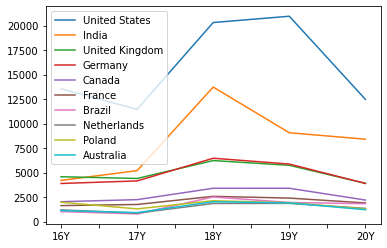

In [232]:
pd.DataFrame({'16Y': df16['country'].value_counts(),
              '17Y': df17['Country'].value_counts(),
              '18Y': df18['Country'].value_counts(),
              '19Y': df19['Country'].value_counts(),
              '20Y': df20['Country'].value_counts()
             }).dropna().astype('int32').sort_values(by='20Y', ascending=False)[:10].T.plot()

<AxesSubplot:>

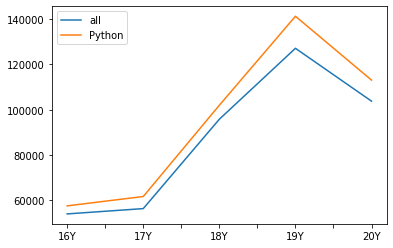

In [244]:
pd.DataFrame({'16Y': [df16['salary_midpoint'].mean(), _df16.loc[_df16['Python'] == 1]['salary_midpoint'].mean()],
              '17Y': [df17['Salary'].mean(), _df17.loc[_df17['Python'] == 1]['Salary'].mean()],
              '18Y': [df18['ConvertedSalary'].mean(), _df18.loc[_df18['Python'] == 1]['ConvertedSalary'].mean()],
              '19Y': [df19['ConvertedComp'].mean(), _df19.loc[_df19['Python'] == 1]['ConvertedComp'].mean()],
              '20Y': [df20['ConvertedComp'].mean(), _df20.loc[_df20['Python'] == 1]['ConvertedComp'].mean()]
             }, index=['all', 'Python']).T.plot()

<AxesSubplot:>

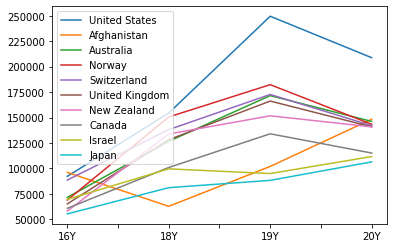

In [230]:
pd.DataFrame({'16Y': _df16.groupby('country')['salary_midpoint'].mean(),
#              '17Y': _df17.groupby('Country')['Salary'].mean(),
              '18Y': _df18.groupby('Country')['ConvertedSalary'].mean(),
              '19Y': _df19.groupby('Country')['ConvertedComp'].mean(),
              '20Y': _df20.groupby('Country')['ConvertedComp'].mean()
             }).dropna().astype('int32').sort_values(by='20Y', ascending=False)[:10].T.plot()

In [184]:
python_salary = pd.DataFrame({'16Y': _df16.loc[_df16['Python'] == 1].groupby('country')['salary_midpoint'].mean(),
              '17Y': _df17.loc[_df17['Python'] == 1].groupby('Country')['Salary'].mean(),
              '18Y': _df18.loc[_df18['Python'] == 1].groupby('Country')['ConvertedSalary'].mean(),
              '19Y': _df19.loc[_df19['Python'] == 1].groupby('Country')['ConvertedComp'].mean(),
              '20Y': _df20.loc[_df20['Python'] == 1].groupby('Country')['ConvertedComp'].mean()
             }).dropna().astype('int32').sort_values(by='20Y', ascending=False)

<AxesSubplot:>

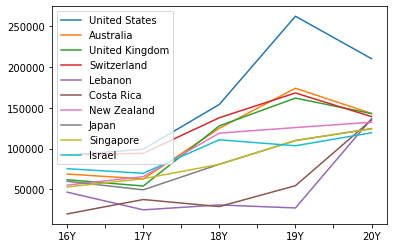

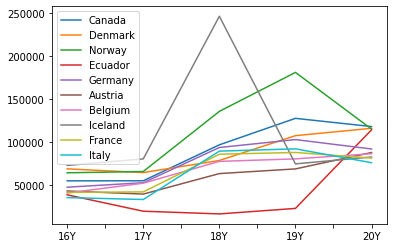

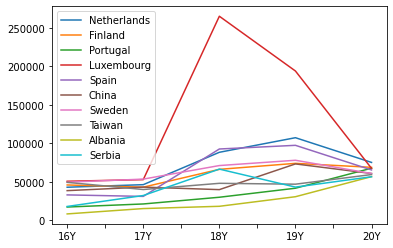

In [210]:
python_salary[:10].T.plot()
python_salary[10:20].T.plot()
python_salary[20:30].T.plot()

United States     5964
India             2670
Germany           1712
United Kingdom    1621
Canada            1011
France             833
Brazil             635
Netherlands        544
Australia          524
Poland             509
Name: Country, dtype: int64

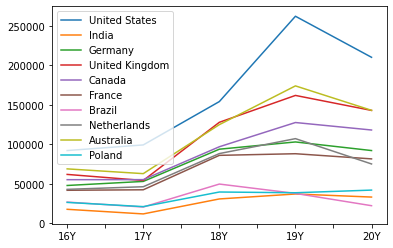

In [227]:
python_salary.loc[_df20.loc[_df20['Python'] == 1]['Country'].value_counts()[:10].index].T.plot()
_df20.loc[_df20['Python'] == 1]['Country'].value_counts()[:10]

<AxesSubplot:>

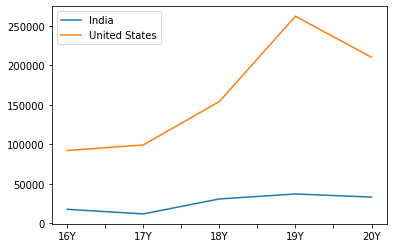

In [206]:
python_salary.loc[['India', 'United States']].T.plot()